# Polynomial Regression with minterpy

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import minterpy as mp

## Problem
In regression, we try to find the best choice of parameters for a model that fits the data well. Polynomial regression allows you to fit your data with polynomial models. Here, we demonstrate this for a sample problem in 2D. The values of some function are given at several locations. Given this information, we try to find a polynomial model fits the model best (in the least square error sense).

## Generate groundtruth data

For demonstration and benchmarking, we generate a 2d data using a combination of transcendental functions.

$s(x,y) = \frac{1}{\sqrt{2}f_0(y)f_0(x) + f_1(y)f_1(x)}$

where
$f_0(z) = \frac{1}{\pi^{1/4} \exp^{-z^2/2}}$
and
$f_1(z) = \frac{2z}{\sqrt{\pi}} f_0(z)$



In [2]:
def f0(z):
    return 1 / (np.pi ** (1 / 4)) * np.exp(-(((z) ** 2) / 2))

def f1(z):
    return np.multiply(f0(z), (2 * z) / (np.pi ** (1 / 2)))

def schroedinger2D(x, y):
    return 1 / (2 ** (1 / 2)) * np.multiply(f0(y), f0(x)) + np.multiply(f1(y), f1(x))

### Locations where the data is known

In [3]:
linear_size = 8
vals = np.linspace(-1.0, 1.0, linear_size)
X, Y = np.meshgrid(vals, vals)
gt_coord = np.c_[X.reshape(-1), Y.reshape(-1)]

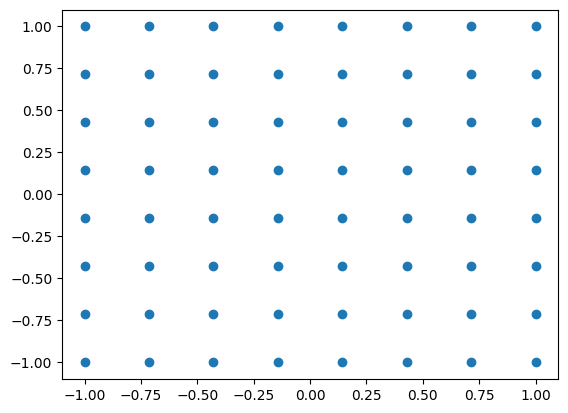

In [4]:
plt.scatter(gt_coord[:,0], gt_coord[:,1])

### Observed groundtruth data

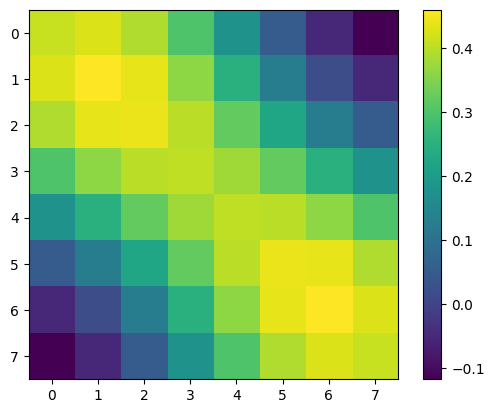

In [5]:
gt_data = schroedinger2D(gt_coord[:, 0], gt_coord[:, 1])
plt.imshow(gt_data.reshape([linear_size,linear_size]))
plt.colorbar()

## Polynomial regression
Now, what we have is some "unknown" data `gt_data` at locations `gt_coord`.

Let us assume a polynomial model in 2D of degree `poly_deg`. We do regression in the Lagrange basis by constructing a linear system of equations. 

$\mathbf{R} x = f$

where $\mathbf{R}$ is the regression matrix. Each column of the $\mathbf{R}$ is obtained by evaluating one of the lagrange monomial at each of the input coordinate. 
$x$ is the unknown Lagrange coefficients and $f$ is the vector of data values at all input coordinates.

### Constructing the polynomial model

In [6]:
poly_deg = 7
mi = mp.MultiIndexSet.from_degree(spatial_dimension=2,
                                 poly_degree=poly_deg)
lag_poly = mp.LagrangePolynomial(mi)

### Constructing the Regression matrix

In [7]:
from minterpy.utils import eval_newton_polynomials

def get_regression_matrix(lag_poly, points):
    """ constructs the regression matrix by evaluating the lagrange monomials on
    all the points.
    :return: (k x N) the value of each Lagrange monomial in Newton form at each point.
    """

    coeffs_newton = mp.get_transformation(lag_poly, mp.NewtonPolynomial).transformation_operator.array_repr_full
    exponents = lag_poly.multi_index.exponents
    generating_points = lag_poly.grid.generating_points
    return eval_newton_polynomials(points, coeffs_newton, exponents,
                     generating_points)


In [8]:
R = get_regression_matrix(lag_poly, gt_coord)

/home/runner/work/minterpy/minterpy/src/minterpy/schemes/barycentric/operators.py:47: UserWarning: building a full transformation matrix from a barycentric transformation. this is inefficient.
  warn(


We can now solve the least square problem by using scipy. This gives us the Lagrange coefficients for the polynomial model.

In [9]:
import scipy
coeffs_lagrange, _, _, _ = scipy.linalg.lstsq(R, gt_data)
lag_poly = mp.LagrangePolynomial(mi, coeffs_lagrange)

We transform the polynomial to Newton basis as it is convenient for polynomial evaluations. 

In [10]:
l2n = mp.get_transformation(lag_poly, mp.NewtonPolynomial)
newt_poly = l2n()

/home/runner/work/minterpy/minterpy/src/minterpy/schemes/barycentric/transformation_fcts.py:109: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 1, 'C', False, aligned=True))
  coeff_slice_transformed = matrix_piece @ slice_in


## Reconstruct the groundtruth using fit polynomial

Now, let us see how good the polynomial model fits the data by evaluating it on the input coordinates.

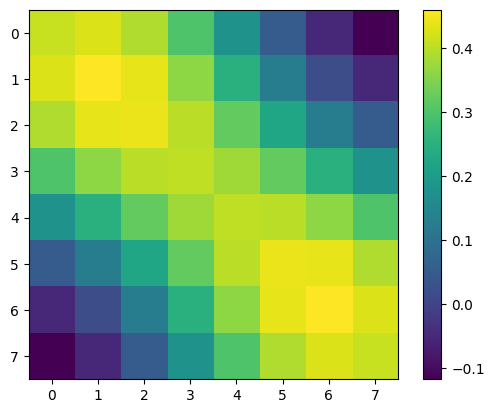

In [11]:
reg_vals = newt_poly(gt_coord)
plt.imshow(reg_vals.reshape([linear_size,linear_size]))
plt.colorbar()

### Fit error

In [12]:
reg_vals = newt_poly(gt_coord)
fit_err = np.max(np.abs(reg_vals - gt_data))
print(f"The L_inf error of fitting is {fit_err}")

The L_inf error of fitting is 6.400898303793312e-05


## Resampling on a finer grid

Since we have the polynomial model, we can evaluate it on any location within the domain of regression.

In [13]:
fs_linear_size = 100
vals = np.linspace(-1.0, 1.0, fs_linear_size)
X, Y = np.meshgrid(vals, vals)
fine_coord = np.c_[X.reshape(-1), Y.reshape(-1)]

In [14]:
reconstruct_vals = newt_poly(fine_coord)

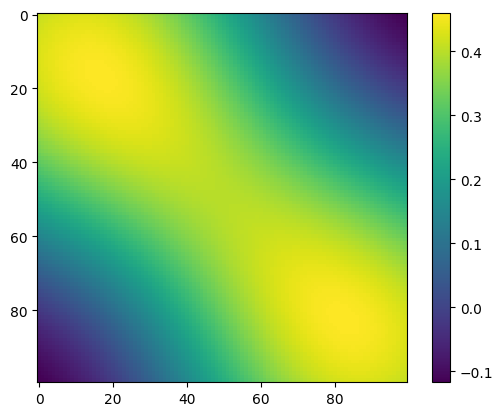

In [15]:
plt.imshow(reconstruct_vals.reshape([fs_linear_size, fs_linear_size]))
plt.colorbar()